# Using Computer Vision Techniques to Count LEGO Pieces

## Starter Code

### Lab 2 - LEGO Time!

The following starter code could be provided to students in case they are new to image processing.

I usually do a couple of examples in class on how to pre-process images (e.g., changing color space, contrast, brightness, size) before I assign a lab such as this one.

Here is one technique for counting the LEGO pieces using information from the images' histograms. I do not offer this code to my students but some instructors might choose to do so as a starting point. It can also be done together in class.

In [103]:
import cv2 as cv
import numpy as np
from matplotlib import pyplot as plt

We display a few images from the dataset (make sure you allow your Google Colab notebook to access your Google Drive).

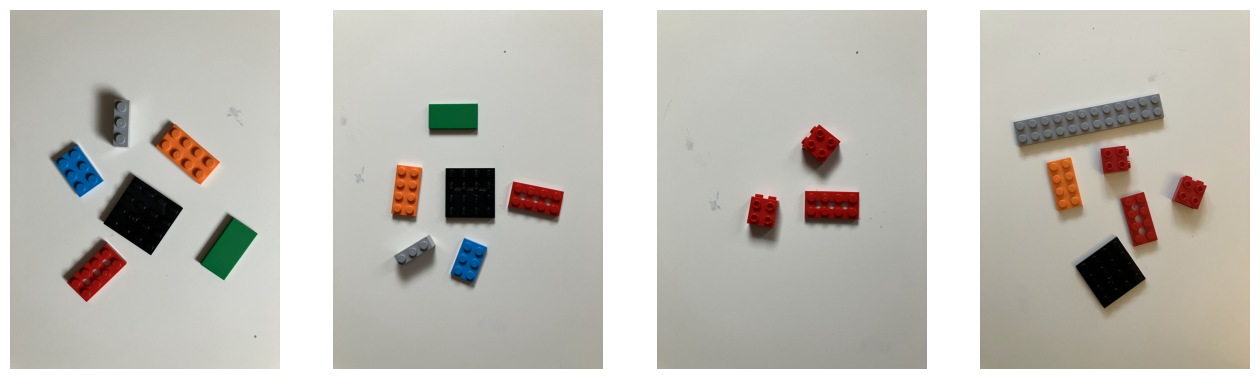

In [104]:
# We read images IMG_0313 to IMG_0316 just as examples but this code has to be applied on all of them.
img_array = [cv.imread("/content/drive/MyDrive/images/LEGO Dataset/IMG_031{}.jpg".format(i)) for i in range(3, 7)]

# Remember that OpenCV reads images as Blue, Green, Red (BGR); we need to change them to RGB.
img_array = [cv.cvtColor(img, cv.COLOR_BGR2RGB) for img in img_array]

# Display the images
def plot_arr(img_array):
  plt.figure(figsize=(16, 8))
  for i in range(len(img_array)):
    plt.subplot(1, len(img_array), i + 1)
    plt.axis("off")
    plt.imshow(img_array[i])
  plt.show()

plot_arr(img_array)

We want to separate foreground from background. Since the background is white, we first convert the images from RGB into grayscale. Keep in. mind that the background is not perfectly white and that the LEGO pieces cast shadows based on the light sources (which we have no control of). This might create a few challenges.

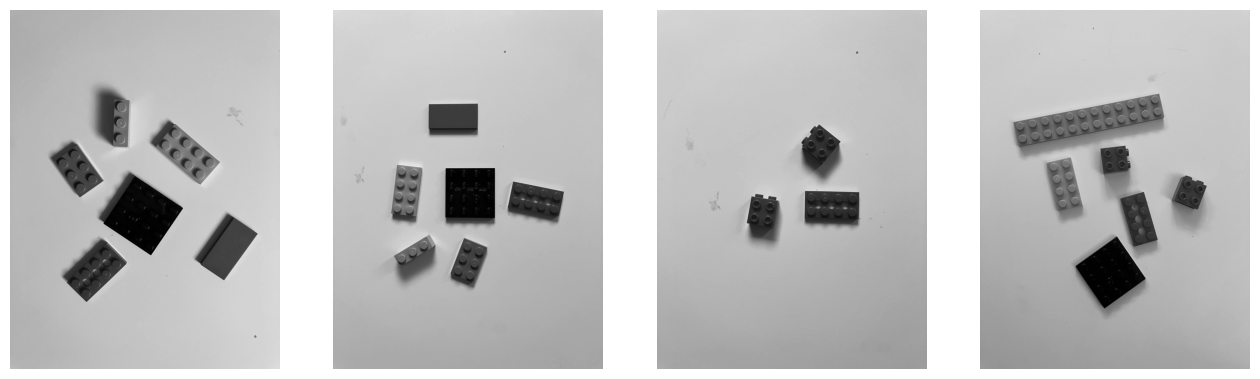

In [105]:
# Display them as grayscale images.
img_gray_array = [cv.cvtColor(img, cv.COLOR_RGB2GRAY) for img in img_array]

def plot_gray_array(images):
  plt.figure(figsize=(16, 8))
  for i in range(len(images)):
    plt.subplot(1, len(images), i + 1)
    plt.axis("off")
    plt.imshow(images[i], cmap='gray')
  plt.show()

plot_gray_array(img_gray_array)

We now plot the images' histograms. We will get an idea of the range of the pixel intensities. Higher pixel intensities will very likely correspond to the background whereas the lower pixel intensities will correspond to the LEGO pieces and their shadows.

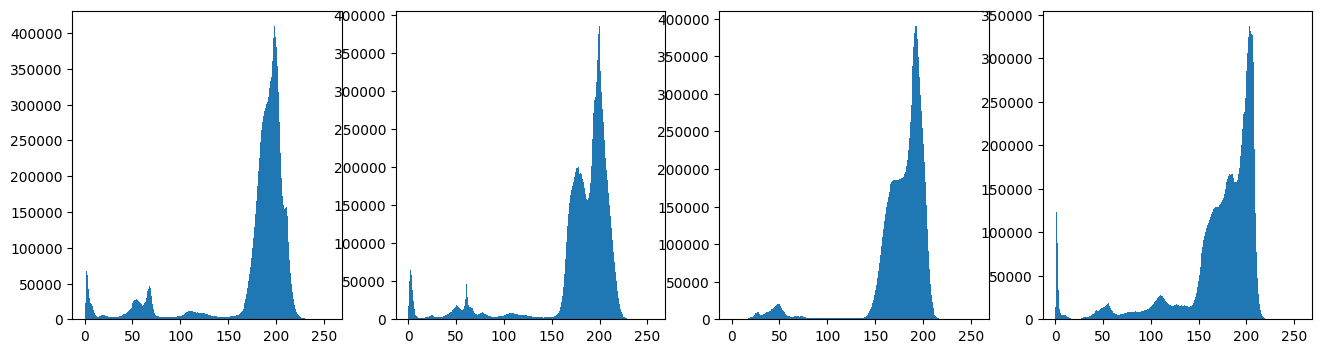

In [106]:
# Plot the histogram
def plot_histogram(images):
    plt.figure(figsize=(16, 4))

    for i, img in enumerate(images):
        plt.subplot(1, len(images), i + 1)
        plt.hist(img.ravel(), 256, [0, 256])

    plt.show()

plot_histogram(img_gray_array)

By visual inspection, we can estimate that a good threshold that can allow us to separate LEGO pieces from background is somewhere between intensity values of 100 and 150. We will use a value of 130 but it is always a good idea to try different thresholds.

Sometimes, the histogram does not offer a clear indicator on which pixels belong to the background and which belong to the foreground. When this happenes, it is a good idea to try to equalize the histogram. Here is some [information on how to achieve this](https://docs.opencv.org/4.x/d5/daf/tutorial_py_histogram_equalization.html).

Ideally, we should have used an algorithm to automatically select the threshold but we will skip this step here.

We use the threshold to separate background from foreground and create binary images.

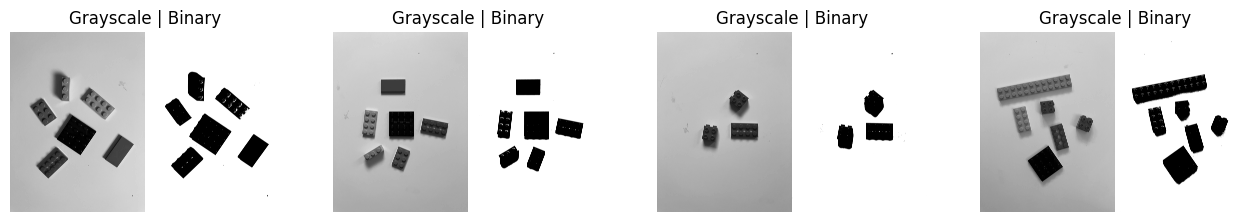

In [107]:
histogram_threshold = 130

def plot_binary(images, threshold):
  img_binary_arr = []
  plt.figure(figsize=(16, 8))
  for i in range(len(images)):
    _, img_binary = cv.threshold(images[i], threshold, 255, cv.THRESH_BINARY)
    img_binary_arr.append(img_binary)
    plt.subplot(1, len(images), i + 1)
    plt.imshow(np.hstack((images[i], img_binary)), 'gray')
    plt.axis("off")
    plt.title("Grayscale | Binary")
  plt.show()
  return img_binary_arr

img_binary_array = plot_binary(img_gray_array, histogram_threshold)

Now that we have binary images, we are able to find contours. More [information about contours is available here](https://docs.opencv.org/3.4/d3/d05/tutorial_py_table_of_contents_contours.html).

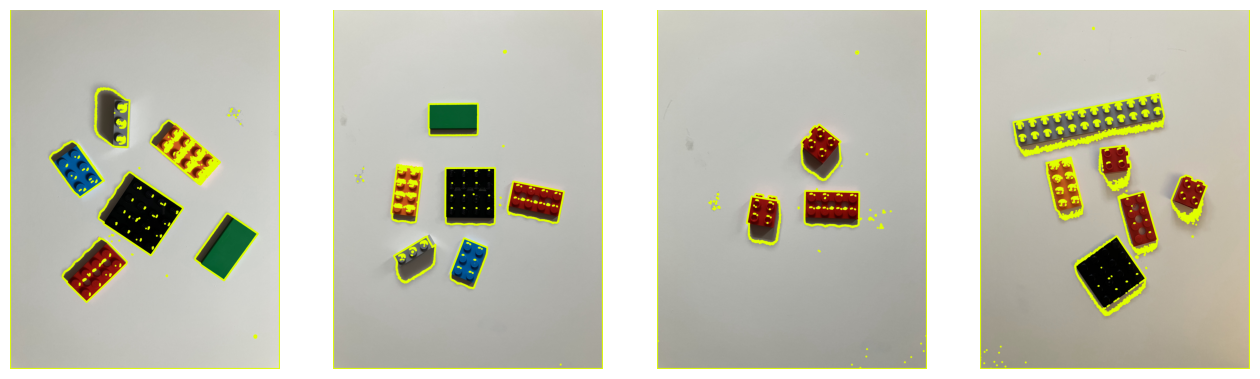

In [108]:
def plot_contour(color_images, binary_images):
  contours_array = []
  plt.figure(figsize=(16, 8))
  for i in range(len(color_images)):
    # Find all the contours and save them into an array.
    contours, _ = cv.findContours(binary_images[i], cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
    contours_array.append(contours)
    # Highlight the contours
    img_contour = cv.drawContours(color_images[i].copy(), contours, -1, (225, 255, 0), 20)
    plt.subplot(1, len(color_images), i + 1)
    plt.imshow(img_contour)
    plt.axis("off")
  plt.show()
  return contours_array

contours_array = plot_contour(img_array, img_binary_array)

We have found a lot of contours. Some of them are contours of LEGO pieces. However, we have smaller sections highlighted in yellow that do not belong to LEGO pieces. We need to ignore these contours.
The easy way to discard them is by analyzing their size. If it is a contour for a small area, we ignore it.

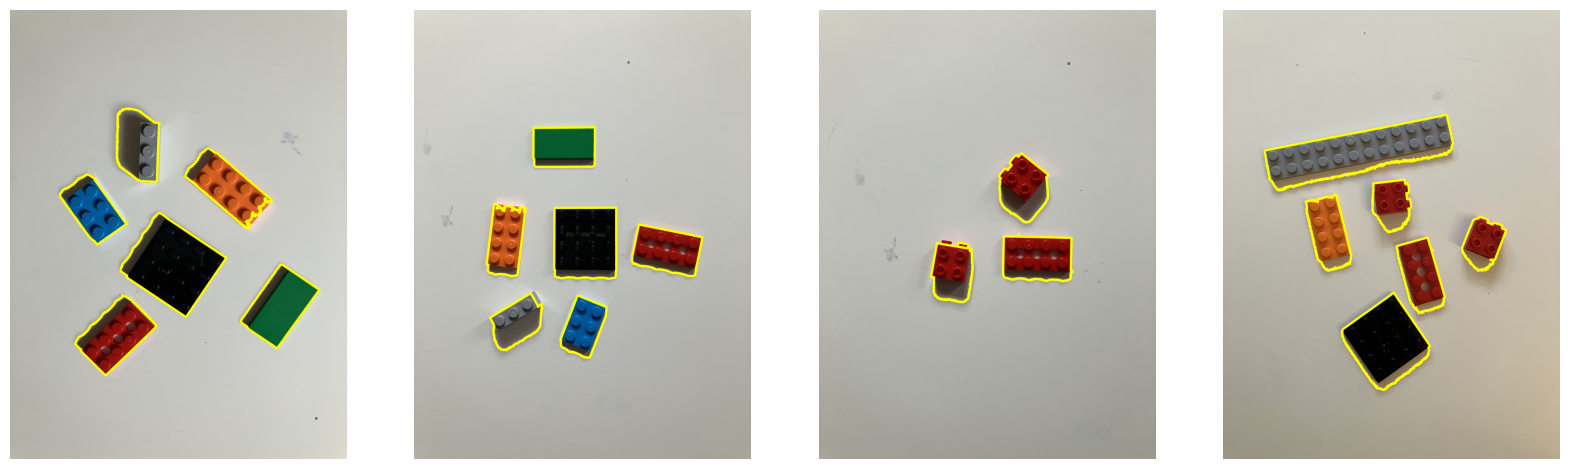

In [109]:
def plot_contours_clean(images, contours):
  number_array = []
  contours_clean_array = []
  image_height, image_width, channels = images[0].shape
  image_area = image_height * image_width
  large_size = (image_area) * 0.90 # Largest contour allowed
  small_size = (image_area) * 0.01 # Smallest contour

  plt.figure(figsize=(20, 8))
  for i in range(len(images)):
    img = images[i]
    rows, cols = img.shape[:2]
    img_copy = img.copy()
    img_contour_clean = np.zeros((rows, cols), np.uint8)

    number_of_legos = 0
    contours_clean = []
    for j, cnt in enumerate(contours_array[i]):
      # Draw only if the size of the contour is greater than a threshold
      if  small_size < cv.contourArea(cnt) < large_size:
        number_of_legos += 1
        contours_clean.append(cnt)
        img_contour_clean = cv.drawContours(img_copy, [cnt], -1, (255, 255, 0), 20)
    number_array.append(number_of_legos)
    contours_clean_array.append(contours_clean)
    plt.subplot(1, len(images), i + 1)
    plt.imshow(img_contour_clean)
    plt.axis("off")
  plt.show()
  return number_array, contours_clean_array

number_array, contours_clean_array = plot_contours_clean(img_array, contours_array)

We finally check how many contours we get. Visually, we can see that they match the number of LEGO pieces.

In [110]:
for i in range(len(number_array)):
  print("{:d} LEGO bricks detected in picture {:d}.".format(number_array[i], i +  1))

6 LEGO bricks detected in picture 1.
6 LEGO bricks detected in picture 2.
3 LEGO bricks detected in picture 3.
6 LEGO bricks detected in picture 4.




---



### Lab 4 - LEGO Time. Again.

There are several tutorials available that demonstrate how to train an object detection model.
* Here is one [tutorial from TensorFlow about object detection](https://www.tensorflow.org/hub/tutorials/object_detection)
* Here is another [tutorial about object detection and finetuning with PyTorch](https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html)

